## AB Testing Project - Udacity 

### Project Purpose

The focus of this project is to design a AB test to determine if Udacity can improve the retention rate of students who stays until the completion of the course after enrolling 14 days free-trial option. For this purpose they have setup two groups, which are **control group** with default features and the **experiment group** with a change introduced. The chnage is to have a message trigger on the web page when users click on the free-trial option, giving them time to think if they have enough time to commit on the course before they enroll on the free-trial plan. Udacity assumes this feature restricts only commited sudents to enroll in the free-trial plan and direct other students to use free course material, which would result in higher retention at the end of 14 days free-trial.

### Experiment Setup 

#### 1. Unit of Diversion/ Unit of Randomization
The unit of diversion is a unique cookie as provided by the Udacity. This cookie tracks the unique users who enroll on the free-trial option on each day by assigning them a user-id. For the users who don't enroll, were not given a user-id to track them even though they were signed in when they have to visit the course overview page.

#### 2. Initial Hypothesis
Based on the project challenge, following initial hypothesis are derrived, which would subject to change later, depending on the data provided and metrics chosen. 

- H0: The treatment has no effect in the number of students who enroll in the free-trial.
- H1: The treatment reduces the number of sudents who enroll in the free-trail.
----

- H0: The treatment has no effect in the number of students who leave at the end or during the free-trial.
- H1: The treatment reduces the number of students who leave during or after the end of free-trial.
----


- H0: The treatment has no effect in the number of students who retain after the end of free-trial period.
- H1: The treatment increases the probability students who stay after the end of free-trail.
----
- H0: The treatment has no effect in the number of students who use free-course material .
- H1: The treatment increases the probability students who start using free- course material.

#### 3. Metric Choice

Udacity has provided a list of metrics which can be used as either an evaluation metric or an invariant metric ,with their practical significance level. Both types of metrics are important in conducting an A/B test.    
- **Invarinat Metric** : Metrics that don't chnage during the whole duration of the experiment and can be considered as control variables. They are important metrics which are use for internal and external sanity checks before performing complex evaluation of the AB test or deploy the test in the production environment.
   - *Number of cookies* : Number of unique daily cookies to browse course overview page (dmin=**3000**)
   - *Number of clicks* : Number of unique daily cookies to click the free-trial button ( dmin=**240**)
   - *Click through probability*: (Number of clicks/ Number of cookies) (dmin=**0.01**)



- **Evaluation Metric**: Metrics which can be meassurable easily and should be sensitive enough to pickup intended chnages and robust to unimportant changes.
Once users enrolled in the free-trial plan , they are tracked through unique user-id. Hence the number of user-ids are only meassured after the treatment is introduced,it is not evenly distributed across control and experiment groups, causing a non-normal distribution and so that it's not considered as an evaluation metric.


   - *Gross Coversion* : (The number of user-ids to complete checkout and enroll in free-trial plan / Number of unique cookies to click on the free-trial button)(dmin =**0.01**)
   - *Retention* : (The number of user-ids to remain enrolled past free-trial plan/ Number of user-ids completed checkout and enrolled in free-trail) (dmin=**0.01**)
   - *Net Conversion* : The number of user-ids to remain enrolled past free-trial plan/ Number of unique cookies to click free-trial button(Gross conversion * Retention)(dmin=**0.0075**)

When deciding the evalutaion metrics, there are few parameters which use to identify if the selected metrics can cause a meaningful difference in the experiment. 
1.  **Statistical Power (1-β)** : The probability of detecting the value of a pre-determined size or higher that value, if the treatment has caused a difference in the meassured metrics.
   - **β** here is the **False Negative** probability or **Type II** error in a statistical test.
   - **False Negative** : Fail to reject the null hypothesis and mistakenly conclude there is no difference in the meassured metrics caused by the treatment, when it really does.
2. **Significance Level(α)** : **False positive** probability or **Type I** error in a statistical test.
    - **False Positive** : Mistakenly rejects the null hypothesis and concludes there is a difference in the meassured metrics caused by the treatment, when there is no real effect.
3.  **Minimum Detectable Effect**- The minimum size of the metric that is considered significant to the business in order to change the default actions.
     - Refer as the **practical siginificance level**

#### 4. Meassuring variability of metrics



**Collecting baseline data**

The baseline values of each metrics are provided by the Udacity. The baseline values are messaured at begining of the experiment as the reference point allowing to compare the effect of the treatment. 

In [673]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import statsmodels

# Importing the csv file 
baseline= pd.read_csv('baseline_values.csv',header=None)
baseline.columns=['Metric','Estimator']
baseline['Metric']=['cookies','clicks','user id','CTR','gross conversion','retention','net conversion']
baseline['dmin']=[3000,240,-50,0.01,-0.01,0.01,0.0075]
baseline.index=["C", "CL", "ID", "CTR", "GC", "R", "NC"]
baseline

,Metric,Estimator,dmin
C,cookies,40000.000000,3000.0000
CL,clicks,3200.000000,240.0000
ID,user id,660.000000,-50.0000
CTR,CTR,0.080000,0.0100
GC,gross conversion,0.206250,-0.0100
R,retention,0.530000,0.0100
NC,net conversion,0.109313,0.0075


**Calculating standard Error**

The standard error for each evaluation metric determines the uncertinity or precision of the observed results, helping determine if observed differences between variations are statisticaly significant and not due to random chance. Standard error estimates the variance of the sample proportion of the metric from its population proportion, as chosen evaluation metrics are probabilities.

***Sizing***

The sample size suggested by Udacity is **5000** cookies.So, that baseline data needs to be scaled accordingly. 

In [674]:
baseline.insert(2,'Scaled Estimator',np.nan)
scaling_factor= 5000/40000
# scaling all metrics which are meaasyres as counts 
for i in ["C", "CL", "ID"]:
    baseline.at[i,"Scaled Estimator"]=baseline.loc[i,"Estimator"]*scaling_factor
baseline

,Metric,Estimator,Scaled Estimator,dmin
C,cookies,40000.000000,5000.0,3000.0000
CL,clicks,3200.000000,400.0,240.0000
ID,user id,660.000000,82.5,-50.0000
CTR,CTR,0.080000,NaN,0.0100
GC,gross conversion,0.206250,NaN,-0.0100
R,retention,0.530000,NaN,0.0100
NC,net conversion,0.109313,NaN,0.0075


***Assumptions***

 
- The fundamental assumption which is made when performing parametric tests is assuming a normal distriution in the sample distribution of the chosen metric, in order to allow compute p-values and significance levels.
-  In order to allow analytical estimate of the standard error of each evaluation metric, the sample distribution of them should be known binomial,normal and a large enough sample size allowing central limit theorem(CLT)
-  This get rids of the need of doing empirical estimation which require bootstrapping samples and computationaly expensive.

For the A/B test: 
- The unit of diversion is same as the unit of analysis (denominator) in all evaluation metrics. So, that outcomes can be model as **bernouli trials** for each entity making the sample proportion follow a **binomially dristribution**.
- According to **Central Limit Theorem(CLT)**, the binomial distribution of the sample proportion approaches a **normal distribution** when the sample size is large enough, assumption of normal distribution can be used even though the underline distribution is binomial.
- Since 5000 cookies, 400 clicks and 83 user_ids are large enough sample size, its assumed sample proportion distribution of each evaluation metric approaches a normal distribution. It can be further verified using the formula ```np≥10 and n(1−p)≥10```
       


In [675]:
# calculating the validity of the metrics for normality assumption 
def Normal_A(n,p,metric):
    if n*p >10 and n*(1-p) >10:
        print(f"{metric}:n={n} is valid")
    else:
        print(f"{metric}:n={n} is not valid")
for i,j in zip(["CL", "ID", "CL"],["GC", "R", "NC"]):
    Normal_A (baseline.loc[i, "Scaled Estimator"], baseline.loc[j,"Estimator"], baseline.loc[j,"Metric"])

gross conversion:n=400.0 is valid
retention:n=82.5 is valid
net conversion:n=400.0 is valid


When population standard error is considered as ```sqrt(p(1-p))```, the standard error is meassured as ```sqrt(p(1-p)/n)```

In [676]:
# calculating the standard error 
def stderror(n,p):
    return (p*(1-p)/n)**0.5

baseline.insert(3,"standard error",np.nan)
for i,j in zip(["CL", "ID", "CL"],["GC", "R", "NC"]):
    baseline.at[j,"standard error"]=stderror(baseline.loc[i]["Scaled Estimator"],baseline.loc[j]["Estimator"])
baseline

,Metric,Estimator,Scaled Estimator,standard error,dmin
C,cookies,40000.000000,5000.0,NaN,3000.0000
CL,clicks,3200.000000,400.0,NaN,240.0000
ID,user id,660.000000,82.5,NaN,-50.0000
CTR,CTR,0.080000,NaN,NaN,0.0100
GC,gross conversion,0.206250,NaN,0.020231,-0.0100
R,retention,0.530000,NaN,0.054949,0.0100
NC,net conversion,0.109313,NaN,0.015602,0.0075


***Experimental Sample Size***

The statistical power of the test is given as **0.80**, hence **β=0.20** and **α=0.05**
Depending on the selected statistical power the experimental sample size needed to meassure each evaluation metric should be calculated. 

To apply two-sample z-test under the normal approximation of binomial distributions, the formual used is,

$n = \frac{(Z_{\alpha/2} \sqrt{2p(1 - p)} + Z_{\beta} \sqrt{p_A(1 - p_A) + p_B(1 - p_B)})^2}{(p_A - p_B)^2}$

Where:

- $Z_{\alpha/2}$ = 1.96 (for a 95% confidence level, α = 0.05)
- $Z_{\beta}$ = 0.84 (for 80% statistical power, β = 0.2)
- $p_{A}$ = Baseline conversion rate (Estimator)
- $P_{B}$= Expected conversion rate in experiment ($p_{A}$+$dmin$)
- $n$ = Sample size per group (Control and Experiment)

In [677]:
baseline.insert(4,"Experimental_N",np.nan)

from scipy.stats import norm

# Statistical parameters
alpha = 0.05  # Significance level
power = 0.8   # Statistical power
Z_alpha = norm.ppf(1 - alpha/2)  # Z-score for 95% confidence
Z_beta = norm.ppf(power)  # Z-score for 80% power

def get_sampleSize (alpha, beta, p, dmin):
    numerator = (Z_alpha * np.sqrt(2 * p * (1 - p)) + Z_beta * np.sqrt(p * (1 - p) + (p+dmin) * (1 - (p+dmin)))) ** 2
    denominator = dmin ** 2
    sample_size_per_group = numerator / denominator
    experimental_sample_size=sample_size_per_group*2
    return experimental_sample_size
   

for i in ["GC","R","NC"]:
        baseline.at[i,"Experimental_N"]=get_sampleSize(alpha=0.05,beta=0.8,p= baseline.loc[i]["Estimator"],
                                                       dmin=baseline.loc[i]["dmin"])
baseline

,Metric,Estimator,Scaled Estimator,standard error,Experimental_N,dmin
C,cookies,40000.000000,5000.0,NaN,NaN,3000.0000
CL,clicks,3200.000000,400.0,NaN,NaN,240.0000
ID,user id,660.000000,82.5,NaN,NaN,-50.0000
CTR,CTR,0.080000,NaN,NaN,NaN,0.0100
GC,gross conversion,0.206250,NaN,0.020231,51115.224893,-0.0100
R,retention,0.530000,NaN,0.054949,78173.219325,0.0100
NC,net conversion,0.109313,NaN,0.015602,54826.675793,0.0075


In [678]:
# calculating the total page views require to test each hypothesis: 
# pageview(cookies)/clicks= 5000/400=12.5
# pageview(cookies)/userid = 5000/82.5= 60.60
print(f"Total pageviews required for GC or Hypothesis I is :{51115.224893*12.5}")
print(f"Total pageviews required for R or Hypothesis II is :{78173.219325*60.606}")
print(f"Total pageviews required for NC or Hypothesis III is :{54826.675793*12.5}")
print(f"Given the dataset, there's no enough data to meassure the Hypothesis IV")

Total pageviews required for GC or Hypothesis I is :638940.3111625
Total pageviews required for R or Hypothesis II is :4737766.13041095
Total pageviews required for NC or Hypothesis III is :685333.4474125
Given the dataset, there's no enough data to meassure the Hypothesis IV


In [679]:
baseline.insert(5, "pageviews",np.nan)
pageviews_dict = {"GC": 638940.32,"R": 4737766.13,"NC": 685333.48}
for i in ["GC","R","NC"]:
        baseline.at[i,"pageviews"]=pageviews_dict[i]
baseline

,Metric,Estimator,Scaled Estimator,standard error,Experimental_N,pageviews,dmin
C,cookies,40000.000000,5000.0,NaN,NaN,NaN,3000.0000
CL,clicks,3200.000000,400.0,NaN,NaN,NaN,240.0000
ID,user id,660.000000,82.5,NaN,NaN,NaN,-50.0000
CTR,CTR,0.080000,NaN,NaN,NaN,NaN,0.0100
GC,gross conversion,0.206250,NaN,0.020231,51115.224893,638940.32,-0.0100
R,retention,0.530000,NaN,0.054949,78173.219325,4737766.13,0.0100
NC,net conversion,0.109313,NaN,0.015602,54826.675793,685333.48,0.0075


***Experiment Duration and Exposure***

The percentage of Udacity's traffic which should be diverted into the experiment must be calculated in order to determine the duration of the experiment. Considering there are no other experiments perform simaltaneously during this time, 100% of the traffic can be divereted into this experiment and 50% of the users then will be in the treatment group. 

The number of daily cookies given in the baseline dataset is 40000.

In [680]:
# Consider 100% traffic route, The number of days required for gross conversion, retention and net conversion 
print(f"The days required  to conduct the experiment with net conversion, retention and gross conversion is :{round(4737766.113/40000,0)}")
print(f"The days required to conduct the experiment with net conversion and gross conversion is :{round(685333.48/40000,0)}")

The days required  to conduct the experiment with net conversion, retention and gross conversion is :118.0
The days required to conduct the experiment with net conversion and gross conversion is :17.0


Due to seasonality and risk of using 100% of traffic in the experiment, the duration of the gross conversion and net conversion can be further extended by 17 more days by diverting only 50% of traffic in this expxeriment.

In [681]:
# By considering 50% of the traffic, the duration can be further reduced and experiment can be more efficient 
# 50% traffic
print('The days required for the experiment with 50% traffic for gross conversion and net conversion, is : ', 
      round(685333.48/(40000*0.5)),' days')

The days required for the experiment with 50% traffic for gross conversion and net conversion, is :  34  days


***Multiple Hypothesis*** 

As multiple hypothesis were initially made for this project, if it was decided to perform the A/B test with multiple hypothesis, then statistical parameters such as p value should be compared against Family Wise Error Rate( FWER).
  - **FWER** : The probability of making at least one Type I error (false positive rate)
  - **Boneferroni correction method**: The correction to the significance level(α) to control the FWER

If performing multiple hypothesis tests, it require more pageview count which is 118 days. Doing this could be risky due to several reasons. It can cause high opportunity cost due to long duration of the experiment. As well as if the treatment harms the user experience, it can lead to degradation of conversion rates and have the trend unnoticed for a long time leading a huge business risk. Considering all above conerns,we will remove retention as an evalutaion metric and use only gross conversion rate and net conversion as only evaluation metrics. Especially since net conversion is a product of rentention and gross conversion, so that we might be able to draw inferences about the retention rate from the other two.

Using only gross conversion and net conversion simplify the A/B test to use only Hypothesis III.

### Data Analysis

In [682]:
# loading data 
control=pd.read_csv('control.csv')
experiment=pd.read_csv('Experiment.csv')

In [683]:
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [684]:
experiment.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


Given by Udacity, each column is defined as : 

- `Pageviews`: Number of unique cookies to view the course overview page that day.
- `Clicks`: Number of unique cookies to click the course overview page that day.
- `Enrollments`: Number of user-ids to enroll in the free trial that day.
- `Payments`: Number of user-ids who who enrolled on that day to remain enrolled for 14 days and thus make a payment. (Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns.)



In [685]:
# Count the duration of each group which is count of entries 
print( f'control :\n{control.count()}')
print(f'\n')
print( f' experiment:\n{experiment.count()}')

control :
Date           37
Pageviews      37
Clicks         37
Enrollments    23
Payments       23
dtype: int64


 experiment:
Date           37
Pageviews      37
Clicks         37
Enrollments    23
Payments       23
dtype: int64


In [686]:
# Calculate the samlpe size for each group and experiment 
print(f'sample size of control group : {control['Pageviews'].sum()}')
print(f'sample size of experiment group :{experiment['Pageviews'].sum()}')
print(f'sample size of the experiment : {control['Pageviews'].sum()+experiment['Pageviews'].sum()}')

sample size of control group : 345543
sample size of experiment group :344660
sample size of the experiment : 690203


***Sanity checks for internal and external test validity***

To ensure the experiment will run properly, sanity checks for  internal test validity should be performed on the invariant metrics. As invariant metrics should stay constant throughout the duration of the experiment, there should be no significant difference between these metrics in the control and experiment group. The invariant metrics selected for this project are: 

 - Number of clicks
 - Number of cookies
 - click through probability

***Cookies***

The number of unique cookies of the experiment is the count of pageviews which is the sample size of each group.The experiment group has a larger smaple size than the control group, causing a imbalanced data distribution between two groups. It is important to determine if the effect of this imbalance distribution has a small effect or larger effect. The presence of the  **Sample Ratio Mismatch (SRM)** of the two groups can be determined by usig a **Chi_square goodness of fit test** or by calculating **Sample Size Ratio**. 

*Method I* :

${Sample Size Ratio} = \frac{\max(n_A, n_B)}{\min(n_A, n_B)}$

- If Ratio >0.8 , then sample sizes are balanced and test should perform well.
- If 0.5 < Ratio ≤ 0.8, then sample sizes are moderately imbalanced.
- If Ratio ≤ 0.5, then sample sizes are highly imbalanced.

*Method II*

${chi^2}=\sum\frac{(O_i-E_i)^2}{E_i}$

- if p_value < significance level, then a SRM maybe present in the experiment
- if p_value >= significance level, then a SRM may not presert

In [687]:
#calculating the sample size ratio using method I

control_pageviews= n_A
experiment_pageviews=n_B

n_A=345543
n_B=344660

ratio=max(n_A,n_B)/min(n_A,n_B)
print(f" sample size ratio : {ratio}")

 sample size ratio : 1.0025619451053212


Since the sample size ratio of **1.0025** is larger than 0.8, the size distribution between control and experiment groups is considred as a balanced distribution and should be good to perform the A/B test.

In [688]:
# Statisticaly evaluate using chi square test method II

observed=[n_A,n_B]
Expected=[(n_A+n_B)/2, (n_A+n_B)/2]

from scipy.stats import chisquare 
chi=chisquare(observed,Expected)
print(f"p_value is :{chi[1]}")
if chi[1]>0.05:
    print(f"Sample Ratio mismatch is not present")
else:
    print(f"sample Ratio mismatch is present")


p_value is :0.2878496417065941
Sample Ratio mismatch is not present


***Clicks***

In order to check if the count of clicks was evenly distributed among both groups and to validate the randomization several statistical tests can be performed.If considerd, being assigned to the control group as a success, the binominal distribution can be used to model the number of successes in the given sample (treatment+control) a **binomial test** with calculating the **confidence intervals(CI)** can be performed as a sanity check.

*Method I* :

$CI = {[\hat{p} − 𝑍(1−𝛼/2) * SE;  \hat{p}+ 𝑍(1−𝛼/2) * SE]}$

where:
 - $ \hat{p}$ = sample proportion
 - $𝑍(1−𝛼/2)$= critical value of the confidence interval 
 - $SE$ = standard error of the proportion

If proportion of number of successs in the sample is within the interval,then there is no significance difference between the data distribution between control and experiment groups.

*Method II* :

Alternatively, **one-proportion z-test** can be performed as a sanity check to determine if any of the control or experiment group has got lesser or higher than the 50% of the data which is the count of clicks:

$Z  = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1 - p_0)}{n}}}$

where:
   - $\hat{p}$ = sample proportion (number of successes divided by the total sample size),
   - $p0$ = hypothesized population proportion,
   - $n$ = sample size.


If P value >= significance level, then SRM may not present in the experiment.

In [689]:
# calculating the proportion of success and CI usig method I 

# assume being assigned to control group as a success event 
control_clicks=control['Clicks'].sum()
experiment_clicks=experiment['Clicks'].sum()
total_clicks = control_clicks+experiment_clicks
p_control=control_clicks/total_clicks

from statsmodels.stats.proportion import proportion_confint
ci_lower,ci_upper = proportion_confint(count=control_clicks, nobs=total_clicks, alpha=0.05, method="wilson")

print(f"control clicks : {control_clicks}")
print(f"experiment clicks : {experiment_clicks}")
print(f"Proportion assigned to Control Group: {p_control:.4f}")
print(f"95% Confidence Interval for Control Group Assignment: ({ci_lower:.4f}, {ci_upper:.4f})")
print(f'\n')
if p_control >ci_lower and p_control <ci_upper :
    print(f"Since the p_value is {p_control} and it lies within the confidence interval, there is no significant difference between the data distribution between groups, a SRM is not present")
else:
    print(f" SRM may present in the experiment")



control clicks : 28378
experiment clicks : 28325
Proportion assigned to Control Group: 0.5005
95% Confidence Interval for Control Group Assignment: (0.4964, 0.5046)


Since the p_value is 0.5004673474066628 and it lies within the confidence interval, there is no significant difference between the data distribution between groups, a SRM is not present


In [690]:
#Calculate Z statistic and p value using Method II

# Check if the control group has 50 % of the total users or lesser or higher 

control_clicks=control['Clicks'].sum()
experiment_clicks=experiment['Clicks'].sum()
total_clicks = control_clicks+experiment_clicks

p_hat=control_clicks/total_clicks # Observed proportion
p_0=0.5   # Expected proportion 

from statsmodels.stats.proportion import proportions_ztest
z_statistic, p_value=proportions_ztest(count=control_clicks,nobs=total_clicks,value=p_0,alternative='two-sided')

print(f'p_value : {p_value}')                                     

if p_value>0.05 :
    print(f"Since the p_value is {p_value} and its higher than alpha, proportion is not significantly different and groups are balanced.")
else:
    print(f" Proportion of users in control group is significantly different from 50% and a SRM may present.")

                                      

p_value : 0.8238676283042462
Since the p_value is 0.8238676283042462 and its higher than alpha, proportion is not significantly different and groups are balanced.


***Click Through Rate (CTR)***

Since the normal approximation can be assumed due to large sample size, **two proportions z test** can be used to determine if the population of the each groups are significantly different.Alternatively  **confidence intervals** can be used as another satistical test for validity of the sanity check, by assuming a binomial distribution in the underline data distribution of each group.



$Z = \frac{(\hat{p}_1 - \hat{p}_2)}{\sqrt{p_{pooled}(1 - p_{pooled}) \left( \frac{1}{n_1} + \frac{1}{n_2} \right)}}$


Where:
- $ \hat{p}_1$ = Observed proportion in group 1
- $ \hat{p}_2$= Observed proportion in group 2
- $p_{pooled} = \frac{x_1 + x_2}{n_1 + n_2}$ = Pooled proportion
- $n_1$, $ n_2$ = Sample sizes of each groups



In [691]:
# Statistical evaluation using two proportions z test

control_CTR = control_clicks/control_pageviews 
experiment_CTR=experiment_clicks/experiment_pageviews

successes=[control_clicks,experiment_clicks]
samples=[control_pageviews,experiment_pageviews]

from statsmodels.stats.proportion import proportions_ztest
z_statistic,p_value=proportions_ztest(successes, samples, alternative="two-sided")

print(f'p_value : {p_value}')   
if p_value >0.05 :
    print(f"Since the p_value is {p_value} and its higher than alpha, CTR proportion is not significantly different and groups are balanced.")
else:
    print(f" Proportion are significantly different from 50% and a SRM may present.")

                 


p_value : 0.9317359524473912
Since the p_value is 0.9317359524473912 and its higher than alpha, CTR proportion is not significantly different and groups are balanced.


Now, the experiment passed sanity checks for internal test validity for all three of the selected invariant metrics which are number of clicks, number of pageview cookies and click through probability/rate. With this its ready to proceed with the A/B test to analyze the evaluation metrics.

#### Test Analysis

Payments were tracked 14 fewer days than the other metrics in the dataset, given their start date.Looking at the loaded data, the payments are tracked for 37 days, which is 23 days to get enrolled and 14 days afterwards to make a payment. To be fully accountable for the 14 days free trial period only 23 days is considered as the duration of the experiment. 
So that first 23 entries of the each datasets is enough to compute statistical meassures. This could alter the targeted sample size of the experiment. True sample size should be used for statitical computations in the evaluation metrics.

In [692]:
#compute true sample size 

True_n=control.iloc[:23]["Pageviews"].sum() + experiment.iloc[:23]["Pageviews"].sum()
print ( f" True sample size : {True_n}")

 True sample size : 423525


*Hypotheis Revised*

Gross Conversion (CG)
- **H₀**: $GC_{\text{experiment}} = GC_{\text{control}} $
- **H₁**: $GC_{\text{experiment}} \neq GC_{\text{control}}$

Net Conversion (CN)
- **H₀**: $ NC_{\text{experiment}} = NC_{\text{control}}$
- **H₁**: $ NC_{\text{experiment}} \neq NC_{\text{control}}$

*Graphical visualization of Evaluation Metrics*

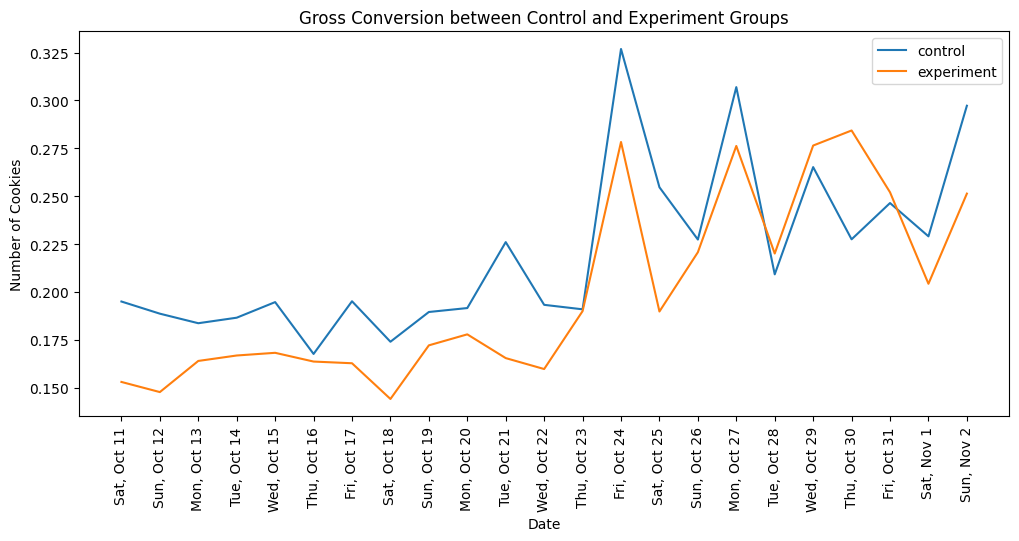

In [693]:
 # gross conversion
plt.figure(figsize=(12,5))
control_sliced= control[:23]
experiment_sliced=experiment[:23]
x = control_sliced['Date']
line1 = plt.plot(x ,control_sliced['Enrollments']/control_sliced['Clicks'],label = 'control')
line2 = plt.plot(x ,experiment_sliced['Enrollments']/experiment_sliced['Clicks'], label = 'experiment')
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Number of Cookies')
plt.title('Gross Conversion between Control and Experiment Groups')
plt.legend()


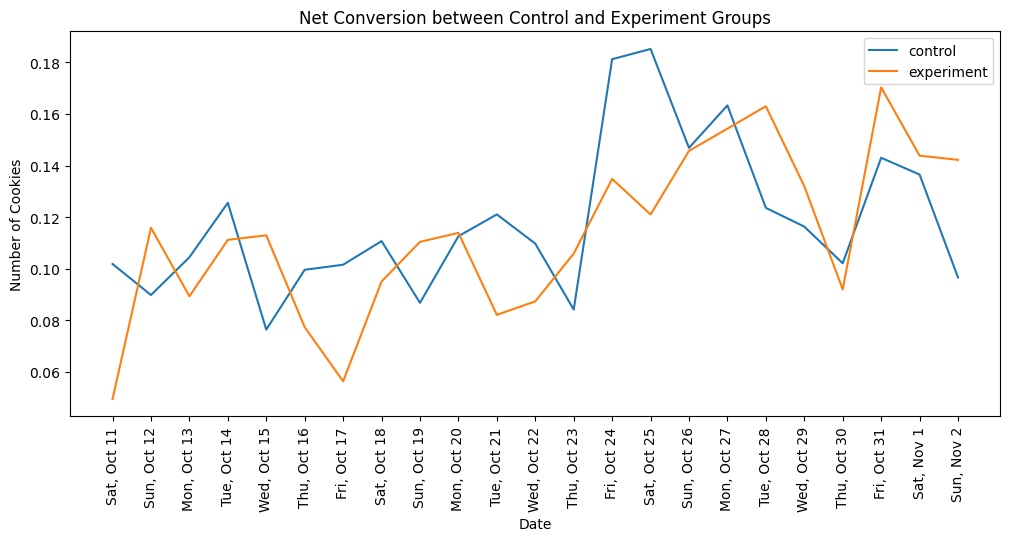

In [694]:
#net conversion 
plt.figure(figsize=(12,5))
control_sliced= control[:23]
experiment_sliced=experiment[:23]
x = control_sliced['Date']
line1 = plt.plot(x ,control_sliced['Payments']/control_sliced['Clicks'],label = 'control')
line2 = plt.plot(x ,experiment_sliced['Payments']/experiment_sliced['Clicks'], label = 'experiment')
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Number of Cookies')
plt.title('Net Conversion between Control and Experiment Groups')
plt.legend()


Based on the both plots, on Oct 24 th , there was a huge peak in the conversion rates in both control and experiment groups, which needs further investigation about this days, if there were any special offers or discounts for the users browsing the website.

***Practical Significance and Statistical Significance***

*Statistical Siginificance*

- In order to check if the observed difference between the sample and experiment groups are statisticaly significant, statistical method , **two proportions z test** can be used to compute the *p_value* associated with the *Z_statistic* and compare it against the given siginificance level (*alpha*). 
- **95 % confidence intervals** can be computed for the difference between metrics to check if near 0 value lies within the interval, in order to determine the statistical significance of the test. 

*Practical Significance*

- However, having the test statistically siginificant is not enough to launch the targeted features.The impact must be higher than the *minimum detectable effect (dmin)* in order to considre the effect as practical significant.
- If the *dmin* is not given then **cohens'h** metric can be calculated to evaluate the size of the effect and determine if its meaningful.
- If the *dmin* is given, the practical siginificance of the test can be found out by checking if the observed difference is higher or lower than the **dmin** and if the **dmin** contains or overlap with **95% confidence interval**.

   - if **dmin** is positive:
        - Check if difference (d) is greater than dmin⁡.
        - Ensure that the entire confidence interval lies to the right of dmin⁡.
        - If both conditions hold → practically significant.

   - if **dmin** is negative (decrease in meaningfulway):
        - Check if difference (d) is smaller than dmin⁡.
        - Ensure that the dmin⁡ is outside and to the right of confidence interval.
        - If both conditions hold → practically significant.

In [695]:
# Checking statistical and practical siginificance for gross conversion

# Let the control be group A and experiment be group B

pA_gc=control_sliced["Enrollments"].sum()/control_sliced["Clicks"].sum()
pB_gc= experiment_sliced["Enrollments"].sum()/experiment_sliced["Clicks"].sum()
# calculate the observed difference between proportions
d=pB_gc- pA_gc
print(f" Observed Difference : {d}")

clicks_A=control_sliced["Clicks"].sum()
clicks_B=experiment_sliced["Clicks"].sum()
enrollments_A=control_sliced["Enrollments"].sum()
enrollments_B=experiment_sliced["Enrollments"].sum()

from statsmodels.stats.proportion import proportions_ztest,proportion_confint

# perform two proportion z test

count=np.array([enrollments_A,enrollments_B])
nobs=np.array([clicks_A,clicks_B])

z_statitics, p_value=proportions_ztest(count=count, nobs=nobs, alternative='two-sided')

#compute confidence intervals

#compute confidence intervals
p_pooled = (enrollments_A + enrollments_B) / (clicks_A + clicks_B)
SE_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/clicks_A + 1/clicks_B))
Z_crit = 1.96  # Z-score for 95% confidence
ci_lower = (pB_gc - pA_gc) - Z_crit * SE_pooled
ci_upper = (pB_gc - pA_gc) + Z_crit * SE_pooled

print(f" p_value : {p_value}")
print(f" confidence interval :[{ci_lower},{ci_upper}]")

# for statistical significance

if p_value < 0.05:
    if ci_lower <= 0 and ci_upper <=0:
        print(f" There is a statistical significance in the difference")
    else:
        print(f" There is no statistical significance in the observed difference")
else:
      print(f" There is no statistical significance in the observed difference")

# for practical significance 

# The dmin (threshould of minimum effect for gross conversion is given as -0.01)
# Hence dmin is a negative value
if d < dmin:
    if ci_upper <= dmin:
        print(f" The effect is practically significant")
    else :
        print(f" The effect made from the difference is not practically significant")
else: 
    print(f" There is no practical significance")

 Observed Difference : -0.020554874580361565
 p_value : 2.578401033720593e-06
 confidence interval :[-0.0291233583354044,-0.01198639082531873]
 There is a statistical significance in the difference
 The effect is practically significant


In [696]:
# Checking statistical and practical siginificance for net conversion

# Let the control be group A and experiment be group B

pA_nc=control_sliced["Payments"].sum()/control_sliced["Clicks"].sum()
pB_nc= experiment_sliced["Payments"].sum()/experiment_sliced["Clicks"].sum()
# calculate the observed difference between proportions
d=pB_nc-pA_nc
print(f" Observed Difference : {d}")

clicks_A=control_sliced["Clicks"].sum()
clicks_B=experiment_sliced["Clicks"].sum()
payments_A=control_sliced["Payments"].sum()
payments_B=experiment_sliced["Payments"].sum()

from statsmodels.stats.proportion import proportions_ztest,proportion_confint

# perform two proportion z test

count=np.array([payments_A,payments_B])
nobs=np.array([clicks_A,clicks_B])

z_statitics, p_value=proportions_ztest(count=count, nobs=nobs, alternative='two-sided')

#compute confidence intervals
p_pooled = (payments_A + payments_B) / (clicks_A + clicks_B)
SE_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/clicks_A + 1/clicks_B))
Z_crit = 1.96  # Z-score for 95% confidence
ci_lower = (pB_nc - pA_nc) - Z_crit * SE_pooled
ci_upper = (pB_nc - pA_nc) + Z_crit * SE_pooled


print(f" p_value : {p_value}")
print(f" confidence interval :[{ci_lower},{ci_upper}]")

# for statistical significance

if p_value < 0.05:
    if ci_lower >= 0 and ci_upper >=0:
        print(f" There is a statistical significance in the difference")
    else:
        print(f" There is no statistical significance in the observed difference")
else:
      print(f" There is no statistical significance in the observed difference")

# for practical significance 

# The dmin (threshould of minimum effect for gross conversion is given as 0.0075)
# Hence the dmin is a positive value:
if d > dmin:
    if ci_lower >=dmin:
        print(f" The effect is practical significant")
    else :
        print(f" The effect made from the difference is not practically significant")
else: 
    print(f" There is no practical significance")

 Observed Difference : -0.0048737226745441675
 p_value : 0.15584068262150205
 confidence interval :[-0.011604624359891718,0.001857179010803383]
 There is no statistical significance in the observed difference
 There is no practical significance


#### Sign Test and Seasonality Analysis
Udacity requires to complete ths result analysis by runing a sign test. Sign test is a non-paramteric test that is use to determine whether there's a consistent directional difference between the control and experiment groups without assuming the normal distribution. Performing this test would violate the fundamental assumptions made in this A/B test in regards to normality of the sample distriibution. Instead of the sign test, an analysis can be performed on the seasonality of the test by breaking down the user acitivity for the day of the week.

In [697]:
# Perform a week analysis to check the seasonality 

week= pd.merge(control_sliced, experiment_sliced, on="Date", how="left")
week["Day"]=week["Date"].apply(lambda x: x[:3])
week.drop(['Pageviews_x','Pageviews_y','Date'],axis=1, inplace=True)
week=week.groupby('Day').sum()
week=week.reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
week["GC_control"]=week["Enrollments_x"]/week["Clicks_x"]
week["GC_experiment"]=week["Enrollments_y"]/week["Clicks_y"]
week["GC_difference"]= week["GC_experiment"]- week["GC_control"]
week["NC_control"]=week["Payments_x"]/week["Clicks_x"]
week["NC_experiment"]=week["Payments_y"]/week["Clicks_y"]
week["NC_difference"]= week["NC_experiment"]- week["NC_control"]
week.drop(["Clicks_x","Enrollments_x","Payments_x","Clicks_y","Enrollments_y","Payments_y"],inplace=True,axis=1)
print(week.head())

     GC_control  GC_experiment  GC_difference  NC_control  NC_experiment  \
Day                                                                        
Mon    0.223408       0.203181      -0.020228    0.124951       0.117694   
Tue    0.207462       0.182530      -0.024932    0.123411       0.116605   
Wed    0.215824       0.198729      -0.017096    0.100249       0.110169   
Thu    0.194419       0.212234       0.017814    0.095860       0.090825   
Fri    0.253879       0.228740      -0.025138    0.140574       0.118690   

     NC_difference  
Day                 
Mon      -0.007257  
Tue      -0.006806  
Wed       0.009921  
Thu      -0.005035  
Fri      -0.021883  


Based on this, most days of the week results a negative effect on the observed difference, which means treatment group had less gross conversions compared to control group as expected .BUt on ** Thursday** , a positive effect was observed and it is important to further analyze the website traffic divertion on Thursdays.

For net conversion, many days results a negative effect on the observed difference, which is not expected and not allign with the main goal of introducing this feature. **Wednesday** is the only day of the week a positive effect was observed.It is also in a small amount as 0.9 % more users in the treatment group than control group made payments.

#### Results Analysis
Based on the results gained from the parametric statistical tests for the gross conversion and net conversion metrics, the effect made by the gross conversion was negative, which means the observed gross conversion in treatment group is around 2% smaller than that of the control group. Since the minimum detectable effect (dmin) for gross conversion falls outside the entire confidence interval and it is smaller than the lower limit of the interval, the observed difference in the gross conversion is considered both statisticaly and practically significant. So, that launching the new features may make a business impact, considering the gross conversion metric.

Looking at the net conversion, the statistical test results shows fail to reject the null hypothesis , hence the observed difference is not statisticaly significant.Therefore, it doesn't have a practical significance. The observed net conversion in experiment group is about 0.48% smaller than the control group with a small negative effect.



#### Conclusion 

Based on the result analysis, this test would help make clearer expectations among students upfront. However since only the gross conversion is statisticaly and practicaly significant, the expectations aimed for increase of the net conversion as in the initial hypothesis wouldn't be acheived by launching this feature. This experiment is effective for reducing the free-trial enrollements but that wouldn't help imporove the payaments made by users. A potential cause of negative effect made by the net conversion could be due to, users who diverted to the use of free course material have improved as a result of the decrese of the gross conversion. Although this test provide students with a clearer expectations when making the enrollment decision, from a business perspective it would have a negative effect on the number users who make payments beyond the free trial period. If the expectation of the Udacity is to improve the revenue alongside of minimizing number of students who leave the free trial plan, I would recommend not to launch this feature.

#### Future Improvements

1. Reduce free-trial cancellations:

The main expectation of the Udacity is to reduce the users leaving the free-trial plan before making the first payment.This effect can be meassured at two reference points, which are before and after enrolling to the free-trial plan. In this experiment we made the hypothesis IV regarding the improvement of users who enroll in free course material. Somehow give data has only meassured user activities after enrolling in the free-trial plan and therefore we had to eliminate testing hypothesis IV. With the decrease of the gross conversion rate, there is definete possibility of increase of the users who enroll in the free course materials. When students have enough understanding from the course material, there's a less probability of them leaving the course for being frustrated if they decided to enroll the paid plan later. So, goal should be to convert the users who use free course material to paid plan later.

For this change, instead of only adding time commitment question to the form, few more questions related to pre-requiste and goal of earning a certification of completion should be added to the form. So, that students who enrolled in the free-trial plan are the ones who fulfill all these criteria and it can guarantee they will retain until the end of the cousre to earn the certificate. Users who don't enroll or enroll in free trial plan can later join the paid plan to earn certificate if they don't fulfill all criterias listed in the form.

To implement this new chnage to the test, we should meassure click through rate of free-course material tab as an evaluation metrics. This would be the number of unique daily cookies that click on the free-course matrial tab ddivided by unique cookies that visited teh course overview page on that day. By collecting a new dataset with thes changes, we can test the experiment for the hypothesis IV and can draw results based on that aspect as well.

2. Improve the current features

For the users who alreday enrolled in the free-trial plan, their user experience can be further improved by providing one on one tutoring support and assigning students into groups. So, that they can share each others their thoughts and knowledge on solving difficult problems or work on course projects as a group. It would also improve the colloarative mindset of students which would pre-train them on working in an industrial environment.